# Step 4.4: Performance of clustering on individual traces

__Step goals:__ Check performance of clustering on individual traces

__Step overview:__
1. Load the data;
2. Load the models and the labels;
3. Calculate clustering metrics;
4. Calculate regression metrics;
5. Visually explore model performance;
6. Generate individual stations.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics import (explained_variance_score, max_error, mean_absolute_error, mean_squared_error, 
                             mean_squared_log_error, median_absolute_error, r2_score, mean_tweedie_deviance)
from sklearn.preprocessing import MinMaxScaler

from tqdm import tqdm
plt.style.use('science')

In [12]:
font = {'size' : 12}
matplotlib.rc('font', **font)

## 1. Load the data

In [3]:
# Load the data
data_type = 'entry' # the clustering was done only on entry data
data = pd.read_csv(f"../data/interim/counts/{data_type}_individual.csv")
n = data.shape[0]
print(f'Clustering was performed on : {n} points.')

# Define X to calculate metrics
X = data["time_stamp"].values
X = X.reshape(-1, 1)

# Generate entry column : each time_stamp quals to 1 (entry)
data['entry'] = np.repeat(1, n)
data = data.groupby('time_stamp').sum()['entry']

Clustering was performed on : 4571040 points.


## 2. Load the models and the labels

In [4]:
# Load the models
models = {}
labels = {}
k_min = 2 # min number of clusters
k_max = 15 # max number of clusters

for k in range(k_min, k_max + 1):
    file_name = f'../models/individual_traces/gmm_{data_type}_{k}.sav'
    with open(file_name, 'rb') as f:
        models[k] = pickle.load(f)
    labels[k] = np.load(f"../data/interim/gmm/individual_traces/labels_{k}_{data_type}.npy", allow_pickle=True)   

## 3. Calculate clustering metrics

In [5]:
# AIC and BIC
# Silhouette, Calinski-Harabasz, Davies-Bouldin
clustering_metrics = {}
aic = {}
bic = {}
# random_state = 12345
# ss = {}
ch = {}
db = {}

delimiter = 1

for key, value in tqdm(models.items()):
    aic[key] = round(models[key].aic(X) / delimiter, 3)
    bic[key] = round(models[key].bic(X) / delimiter, 3)
    # ss[k] = silhouette_score(X, labels[key], random_state=random_state)
    ch[key] = round(calinski_harabasz_score(X, labels[key]) / delimiter, 3)
    db[key] = round(davies_bouldin_score(X, labels[key]), 3)
    
clustering_metrics['AIC'] = aic
clustering_metrics['BIC'] = bic
# clustering_metrics["Silhouette score"] = ss
clustering_metrics["Calinski-Harabasz"] = ch
clustering_metrics["Davies-Bouldin"] = db

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:32<00:00,  6.64s/it]


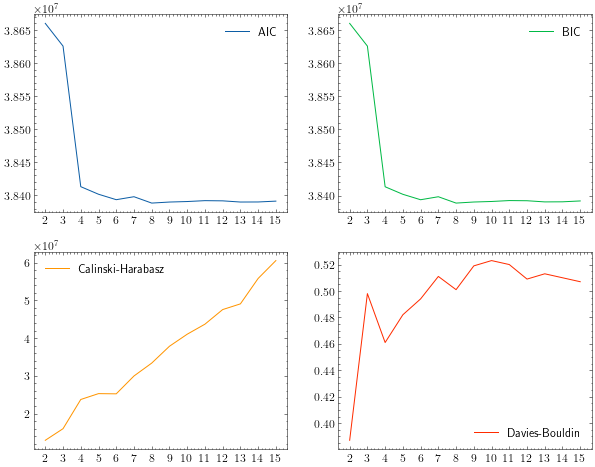

In [14]:
ax = pd.DataFrame(clustering_metrics).plot(subplots=True, layout=(2, 2), figsize=(10, 8), rot=0, xticks=np.arange(k_min, k_max + 1), sharex=False);
# for i in range(0, 4):
#     ax[i, 0].set_xlabel('Number of components')
#     ax[i, 0].set_ylabel('Metric score')
# plt.savefig('../figures/.png', dpi=300)

## 4. Calculate regression metrics

In [7]:
# Generate sample
sampled_data = {}
for k in tqdm(range(k_min, k_max + 1)):
    df = pd.DataFrame(models[k].sample(n)[0].reshape(-1))
    df[0] = df[0].astype(int)
    df[1] = np.repeat(1, n)
    sampled_data[k] = df.groupby(0).sum()

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.04it/s]


In [8]:
# Calculate metrics
regression_metrics = {}
for k in range(k_min, k_max + 1):
    index = sampled_data[k].index.isin(data.index) # make sure that the indeces are equal
    x = sampled_data[k].loc[index,:].values
    y = data.values
    regression_metrics[k] = {'explained_variance_score' : explained_variance_score(y, x), 
                             'max_error' : max_error(y, x), 
                             'mean_absolute_error' : mean_absolute_error(y, x), 
                             'mean_squared_error' : mean_squared_error(y, x), 
                             'mean_squared_log_error' : mean_squared_log_error(y, x), 
                             'median_absolute_error' : median_absolute_error(y, x),
                             'r2_score' : r2_score(y, x), 
                             'mean_tweedie_deviance' : mean_tweedie_deviance(y, x)}

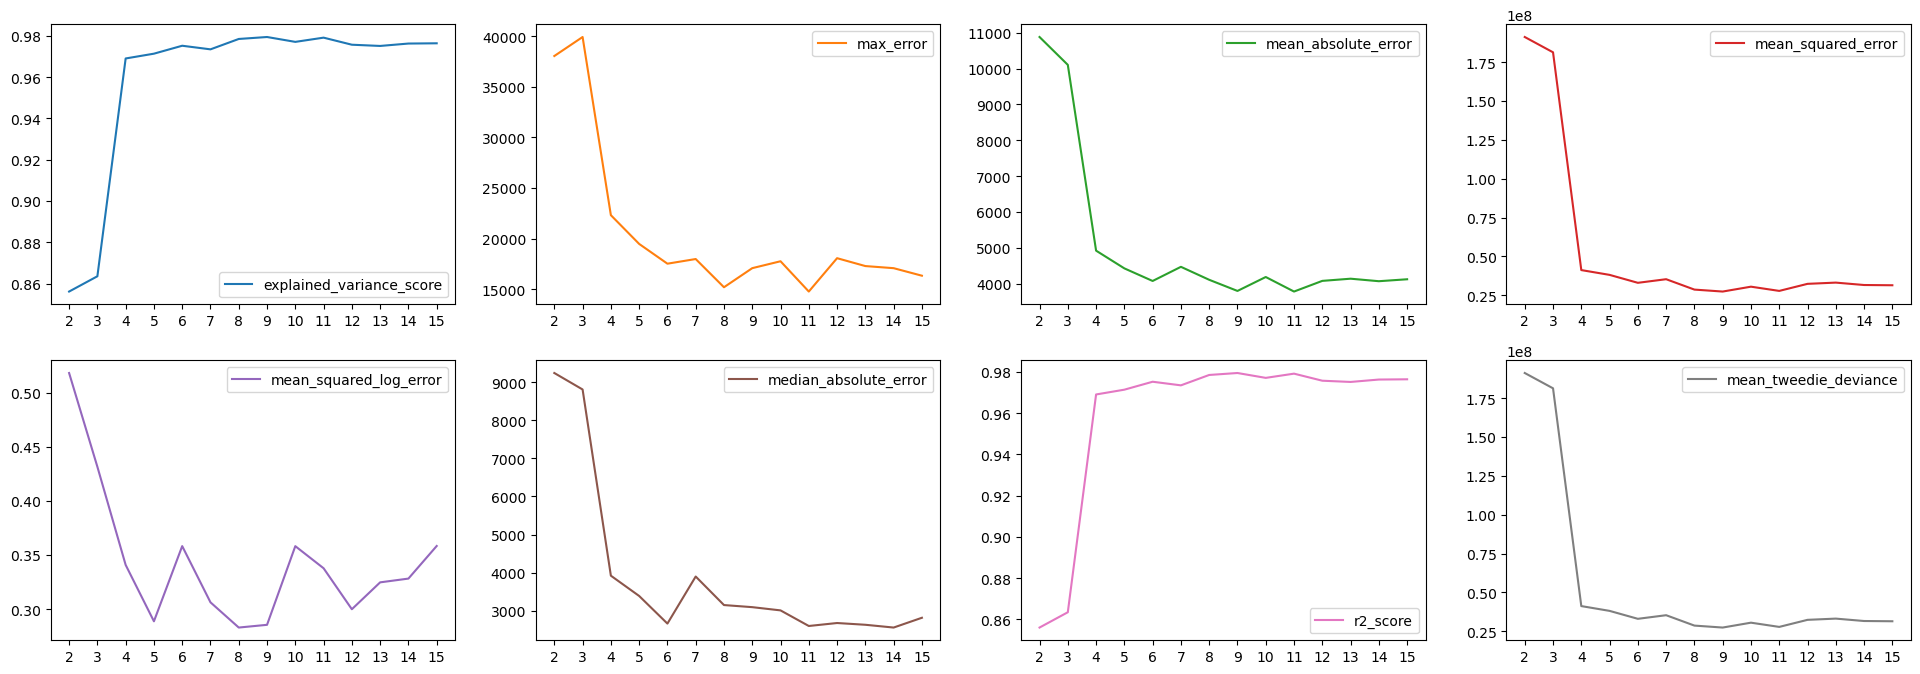

In [24]:
# plt.style.use('default')
pd.DataFrame(regression_metrics).T.plot(subplots=True, layout=(2, 4), 
                                        figsize=(24,8), 
                                        xticks=np.arange(k_min, k_max + 1, 1), rot=0, sharex=False);
# plt.tight_layout()

## 5. Graphically explore model performance

In [15]:
colors = ['#0C5DA5', '#00B945', '#FF9500']

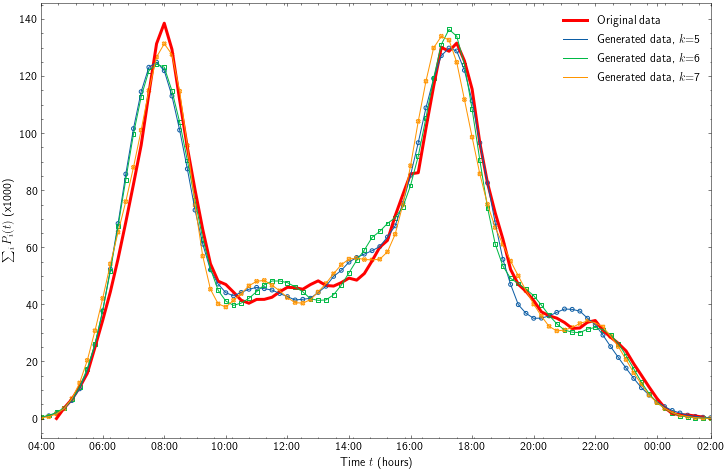

In [16]:
# Generate samples
fig, ax = plt.subplots(figsize=(12,8))

# Plot "original" sampled data
data.div(1000).plot(legend=False, ax=ax, color='red', linewidth=3)

x_ticks = [0, 9, 17, 25, 33, 41, 49, 57, 65, 73, 81, 89, 96]
x_ticks_labels = ["02:00", "04:00", "06:00", "08:00", "10:00", "12:00", "14:00", "16:00", "18:00", "20:00", "22:00", "00:00", "02:00"]

k_min = 5
k_max = 7

markers = ['o', 's', 'X']
i = 0
for k in range(k_min, k_max + 1):
    sampled_data[k].div(1000).plot(ax=ax, legend=False, color=colors[i])
    x = sampled_data[k].index.tolist()
    y = sampled_data[k].iloc[:,:].div(1000).values.tolist()
    ax.scatter(x, y, marker=markers[i], s=15, facecolors='none', edgecolor=colors[i])
    i += 1
    
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticks_labels)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda y, p: format(int(y), ',')))
ax.set_xlim(left=9, right=96)
legend = [f'Generated data, $k$={i}' for i in range(k_min, k_max + 1)]
plt.legend(['Original data'] + legend, frameon=False, loc='upper right')
ax.set_xlabel("Time $t$ (hours)") #, fontsize=12)
ax.set_ylabel(r'$\sum_i P_i(t)$ (x1000)') # , fontsize=12)
plt.savefig('../figures/sfig5.png', dpi=300)

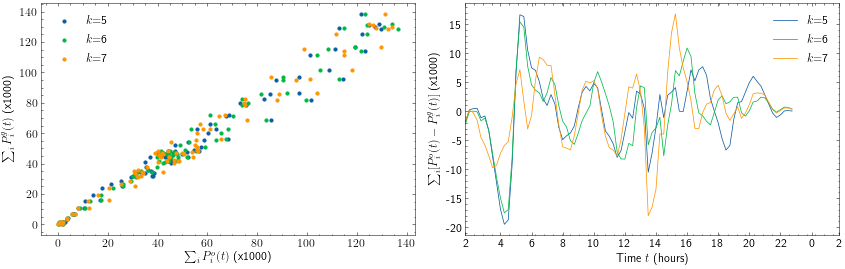

In [52]:
fig, ax = plt.subplots(figsize=(12,4), ncols=2)

k_min = 5
k_max = 7

x_ticks = [0, 9, 17, 25, 33, 41, 49, 57, 65, 73, 81, 89, 96]
x_ticks_labels = ["2", "4", "6", "8", "10", "12", "14", "16", "18", "20", "22", "0", "2"]

# ax[0].plot([0, data.div(1000).max()], [0, data.div(1000).max()], color='red')

for k in range(k_min, k_max + 1):
    index = sampled_data[k].index.isin(data.index)
    x = sampled_data[k].loc[index,:].div(1000).values
    y = data.div(1000).values
    ax[0].scatter(x, y, s=10)
    ax[0].set_xlabel('')
    
    diff = pd.DataFrame(y).subtract(pd.DataFrame(x))
    diff.plot(legend=False, ax=ax[1], linewidth=.75)

legend = [f'$k$={i}' for i in range(k_min, k_max + 1)]
ax[0].legend(legend)

ax[0].set_xlabel(r'$\sum_i P_i^o(t)$ (x1000)')
ax[0].set_ylabel(r'$\sum_i P_i^g(t)$ (x1000)')

ax[1].set_xticks(x_ticks)
ax[1].set_xticklabels(x_ticks_labels)
ax[1].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda y, p: format(int(y), ',')))
ax[1].set_xlim(left=0, right=96)
ax[1].set_xlabel('Time $t$ (hours)')
ax[1].set_ylabel('$\sum_i [P_i^o(t) - P_i^g(t)]$ (x1000)')
ax[1].legend(legend)

plt.tight_layout()